In [1]:
# THis code file has model5 with all mods and most importantly
# with WEIGHT INITIALISATIONS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import requests


import torch
import torch.nn as nn
import torch.nn.functional as F

# use GPU
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [4]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [5]:
# hyper para for GPT2-124M
n_vocab = 50257 # GPT2 vocab size
embed_dim = 768 #embedding dim
seq_len = 256 #max seq len
n_heads = 12 # attention heads
n_blocks = 12 # tranformer blocks
#each transformer block has 12 atention heads
batch_size = 16

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [6]:
# Import tokenzie and split text (Gullivers travels)

text = requests.get('https://www.gutenberg.org/cache/epub/829/pg289.txt').text
print(len(text))
gtTokens = torch.tensor(tokenizer.encode(text), dtype = torch.long)
len(gtTokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (2811 > 1024). Running this sequence through the model will result in indexing errors


6325


2811

In [7]:
# train/test split
train_ratio = .9

#index to split data
test_split_point = int(train_ratio * len(gtTokens))

train_data = gtTokens[:test_split_point]
test_data = gtTokens[test_split_point:]
# in this split 10% of the last part is training set, whi9ch is not a good split
# ideally we would want a random split


# a func that return a batch of data samoples
def get_data_batch(training = True):
    # pick the dataset to use
    if training:
        data = train_data
    else:
        data = test_data

    #pick random idices to start
    ix = torch.randint(len(data) - seq_len, size = (batch_size,))

    #get the data and targets (via broadcasting outer product)
    X = data[ix[:,None] + torch.arange(seq_len)]  # now this is becomes a matrix
    y = data[ix[:,None] + torch.arange(1,seq_len+1)]

    return X,y

#example 
X,y = get_data_batch()
print(f'Input data (size {X.shape}):\n',X)
print(f'\n\nTargets (size {y.shape}):\n',y)

Input data (size torch.Size([16, 256])):
 tensor([[  220,   220,   220,  ...,    13,  2079,    43],
        [35922, 10755,    14,  ..., 30487,  1398,  2625],
        [   14, 21370,    70,  ...,   860,    13,    20],
        ...,
        [  220,   220,  1875,  ...,  9167, 25970,    79],
        [  220,   220,   220,  ...,  5320,  3987,   378],
        [  126,   120,  3556,  ...,   220,   220,   220]])


Targets (size torch.Size([16, 256])):
 tensor([[  220,   220,   220,  ...,  2079,    43,  1238],
        [10755,    14, 25249,  ...,  1398,  2625,  8726],
        [21370,    70,     1,  ...,    13,    20,   642],
        ...,
        [  220,  1875,   198,  ..., 25970,    79,    29],
        [  220,   220,  1279,  ...,  3987,   378,  3556],
        [  120,  3556, 12626,  ...,   220,   220,   220]])


In [8]:
ix = torch.randint(250 - 12, size = (5,))

In [9]:
ix

tensor([ 60, 129,  96,  76, 195])

In [10]:
ix[:,None] #transformerd to col vector

tensor([[ 60],
        [129],
        [ 96],
        [ 76],
        [195]])

In [11]:
ix[:,None] + torch.arange(12)

tensor([[ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71],
        [129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140],
        [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107],
        [ 76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87],
        [195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206]])

In [12]:
train_data[ix[:,None] + torch.arange(12)]

tensor([[25473,     1, 13291, 35922,    70, 19028,    14,    70, 19028,    12,
          4743,   672],
        [ 1279, 28961,  1438,  2625, 13297,    12, 15654,    12,   332,  2649,
             1,  2695],
        [   28,    16,  5320,   198,  1279, 28961,  1438,  2625,  2539, 10879,
             1,  2695],
        [  628,   198,  1279, 28961,  1438,  2625,  1177,   634,     1,  2695,
          2625, 10394],
        [   62,  4449,    17,    39,    62,    52,    80,    55,    57,    85,
            44,  5320]])

In [13]:
train_data[63]

tensor(35922)

# prepare model5

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        
        super().__init__()
    
        #head dimensionality is embed_dim split across the heads
        self.num_heads = n_heads
        self.head_dim = embed_dim // n_heads
    
        # the three Q,K,V weight matrices are init as one, and are split inside attention eqn
        self.QKV = nn.Linear(embed_dim, 3*embed_dim, bias=True)
    
        #final linear projection merges the heads outputs
        self.W0 = nn.Linear(embed_dim, embed_dim, bias=True)
    
    def forward(self, x):
        # extract the dimension size of the inputs(token embedds)
        B, T, E = x.shape # [batch, tokens (or seq_len), embed_dim]
        

        #push data through Q,K and V in one concatenated matrix
        qkv = self.QKV(x) #[batch, seq_len, 3*embed]
        q,k,v = torch.split(qkv, E, dim=2) # each matrix is [B,T,E]

        # reshape to [B,T,nHeads, head_dim]
        # and then transpose to [B, nHeads, T, head_dim]
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1,2) #[B, num_heads, T, head_dim]
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1,2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1,2)

        # Pytorchs SDPA func handles multi head shapes
        out = F.scaled_dot_product_attention(q,k,v,is_causal=True)

        # recombine heads : (B,nHeads,T,head_dim) -> [B,T,E]
        out = out.transpose(1,2).reshape(B,T,E)
    

        #finallt apply linear mixing matrix
        out = self.W0(out)

        return out

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()

        #attention subblock
        self.layernorm_1 = nn.LayerNorm(embed_dim,eps=1e-5)
        self.attn = MultiHeadAttention()

        #feedfwd (MLP) sublayer
        self.layernorm_2 = nn.LayerNorm(embed_dim,eps=1e-5)
        self.mlp_1 = nn.Linear(embed_dim,4*embed_dim,bias=True) # 4x expansion
        self.gelu = nn.GELU()
        self.mlp_2 = nn.Linear(4*embed_dim, embed_dim, bias=True) #4x contraction

    def forward(self,x):

        ## ----attention sublayer ------##
        x_att = self.layernorm_1(x) # pre attn normalisn
        x_att = x + self.attn(x_att) # run through attention, then add pre attn activations

        #MLP
        x_ff = self.layernorm_2(x_att) # pre MLP normlsn
        x_ff = x_att + self.mlp_2( self.gelu( self.mlp_1(x_ff)))
        
        return x_ff
        
        

In [15]:
# the full model class, which calls the previously defined classes

# HERE WE HAVE SOME ADDITIONS FOR WEIGHT INITS
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()

        # token + posn embedds
        self.wte = nn.Embedding(n_vocab, embed_dim) # token embedds
        self.wpe = nn.Embedding(seq_len, embed_dim) # posn embedds

        #n mutliple Transformer blocks
        # * is a unpacking operator, the list of txf blocks goes into input of Sequential()
        self.transformerBlocks = nn.Sequential(*[TransformerBlock() for _ in range(n_blocks)])

        # embedding to output (linear) layer
        self.layernorm_final = nn.LayerNorm(embed_dim,eps=1e-5) # final layernorm after all txf blocks
        #unembed matirx
        self.final_head = nn.Linear(embed_dim, n_vocab, bias=False)
        #final ouput layer (unembedd) tied to token embedd
        self.final_head.weight = nn.Parameter(self.wte.weight)


        self.apply(self.weightInits) #apply the input func (weightInits) iteratively to all elements of this class
    
    def weightInits(self, module):
        
        # init nn.Linear to normal with std=.02
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0, std=.02)

            # init the bias terms to zero
            if module.bias is not None:
                nn.init.zeros_(module.bias)

        # Init nn.Embeddings to Xavier
        if isinstance(module, nn.Embedding):
            nn.init.xavier_normal_(module.weight)
                
    def forward(self, idx):

        #----------embeddings-------------##
        token_emb = self.wte(idx)  # [B,T,E]   T is seq_len and E is embed_dim
        posit_emb = self.wpe(torch.arange(idx.shape[-1],device=device)) #[seq_len, embed_dim]
        x = token_emb + posit_emb #[B,T,E]
        ##--------------------------------##

        #n
        ##--pass through each transformer blocks----##
        x = self.transformerBlocks(x)
        ##-------------------------##

        #-----finally unembeddings----##
        x = self.layernorm_final(x)
        logits = self.final_head(x) # [B,T, n_vocab]
        # logits is [batch, seq_len, n_vocab]
        return logits

    def generate(self,idx,temperature=1.,max_new_tokens=50):
        for _ in range(max_new_tokens):
            # fwd passb
            logits = self(idx[:,-seq_len:]) # [B,T,n_vocab]   get preds, but only from past seq_len tokens 
            logits = logits[:,-1,:] #[B,n_vocab]   extract last tokens logitsto predict the next

            # apply softmax with temp to get prob values over all tokens in vocab - with temp
            probs = F.softmax(logits/temperature,dim=-1) #[B,n_vocab]

            #probabilistically sample next token from distbn
            idx_next = torch.multinomial(probs, num_samples=1) # [batch,1]
            
            #append 
            idx = torch.cat((idx, idx_next),dim=1) #[batch, (tokens+1)]
        return idx

In [16]:
model = LanguageModel().to(device)
X, y = get_data_batch()
X,y = X.to(device), y.to(device)
out = model(X)
print(f'input size: {X.shape}')
print(f'output  size: {out.shape}')

input size: torch.Size([16, 256])
output  size: torch.Size([16, 256, 50257])


In [17]:
# generate new text before any training
startToks = torch.tensor(tokenizer.encode('The man-mountain shall not depart from our dominion')).unsqueeze(0)

# text gen
Y = model.generate(startToks.to(device), max_new_tokens=100)
print(tokenizer.decode(Y[0].tolist()).replace('\r','\n'))

The man-mountain shall not depart from our dominion rebuildingday Whoever nickname Manila 2020 gardowauously violation optimal 259???? Cinema consumer Coleman Exploration McGillaurus Arri transgressucks barbar toes interest purchasing proving Cornell micesiatis derogatorygewater aug modularweet Wanted released 145Britain fluted brainstorm problem effortsermott MakotoOcean drift clerks idealirlf Lug Francisgray Err captainSolar Freedom shout Catholicism partially discusses partneredarray gloves teased AnglicausibleSimonligSymilst afflicted ['aultprettyete experien faces Clare SecondaryExpress Merchagi710 Vander correspond denounce switch mesmerormal lunch Uzaskbringer genomeousGraphics 433


In [23]:
# check the weights disbn
print('mlp bias vector: ', model.transformerBlocks[1].mlp_1.bias.data)
print('std of  mlp weights: ', torch.std(model.transformerBlocks[1].mlp_1.weight.data))
print('std of embedding weights: ', torch.std(model.wte.weight.data))
print('std of position  weights: ', torch.std(model.wpe.weight.data))

mlp bias vector:  tensor([0., 0., 0.,  ..., 0., 0., 0.], device='mps:0')
std of  mlp weights:  tensor(0.0200, device='mps:0')
std of embedding weights:  tensor(0.0200, device='mps:0')
std of position  weights:  tensor(0.0441, device='mps:0')


In [25]:
# Why token embedding had std = 0.02 and position embed has std = 0.04???
# WHY??

# Becuase it is Xavier disbn std = sqrt(2/NdimIN+NdimOut)

In [26]:
np.sqrt(2/sum(list(model.wpe.weight.shape)))

0.04419417382415922

In [28]:
np.sqrt(2/sum(list(model.wte.weight.shape)))  #----> WHY NOT o.02 here????

0.006260708611450578

In [29]:
isinstance(model.wte, nn.Embedding), isinstance(model.wte, nn.Linear)
# so it is Embedding not linear---> then why we got 0.02?

(True, False)

THIS HAPPENED BECAUSE OF THE TYING UP OF EMBEDDING AND UNEMBEDDING MATRIX:
 - unembedding (self.final_head = nn.Linear(embed_dim, n_vocab, bias=False)) is LINEAR
 - as per Python rules, the 2 diff variables point to same memory location
 - as unmebedding came later, wte got changed to Linear

Training the model

In [30]:

# create loss and omptimizer funcitons
loss_function = nn.NLLLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=.001, weight_decay=.01)  

In [31]:
# check loss func with sizes
X,y = get_data_batch()
X = X[0].unsqueeze(0)
y = y[0].unsqueeze(0)
log_probs = model(X.to(device))

print(f'Model inout size: {X.shape}')
print(f'Model out size: {log_probs.shape}')
print(f'Target tokens is  size: {y.shape}')

# flatten
log_probs_flat = log_probs.view(-1, log_probs.shape[-1])

loss  = loss_function(log_probs_flat, y.view(-1).to(device))
print('\nLoss:', loss)

Model inout size: torch.Size([1, 256])
Model out size: torch.Size([1, 256, 50257])
Target tokens is  size: torch.Size([1, 256])

Loss: tensor(-0.1125, device='mps:0', grad_fn=<NllLossBackward0>)


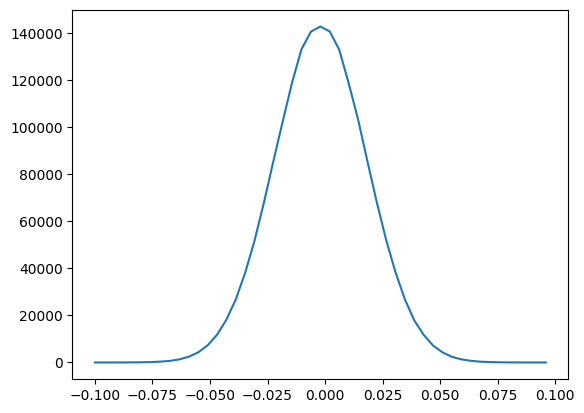

In [37]:
# WHILE TRAINING YOU make a histogram of attention weights to see how it changes during training 

# finding the path to attenton weights
yh,xh = np.histogram(model.transformerBlocks[1].attn.QKV.weight.detach().cpu(), bins=np.linspace(-.1,.1))
plt.plot(xh[:-1],yh)

Now train model

In [42]:
num_samples = 501

#init the loss
train_loss = []
test_loss = []
attn_W_dists = np.zeros((num_samples,100))
attn_W_stds = np.zeros((num_samples,len(model.transformerBlocks)))


for sampli in range(num_samples):
    # get batch of data
    X,y = get_data_batch()

    X,y = X.to(device), y.to(device)
    model.zero_grad()

    #fwd pass
    log_probs = model(X)
    log_probs_flat = log_probs.view(-1, log_probs.shape[-1])  #tokens 0:N-1
    y_flat = y.view(-1) # tokens 1:N
    loss = loss_function(log_probs_flat,y_flat)
    # loss = loss_function(log_probs.view(-1, log_probs.shape[-1]),y.view(-1))

    #bckprop
    loss.backward()
    optimizer.step()

    # sum the batch loss
    train_loss.append(loss.item())

    if sampli%50==0:
        hidx = 4 # jsut from one transfomer block
        qkvWeights = model.transformerBlocks[hidx].attn.QKV.weight.detach().cpu()
        yh,xh = np.histogram(qkvWeights, bins=np.linspace(-.1,.1,101))
        attn_W_dists[sampli,:] = yh
        for hidx in range(len(model.transformerBlocks)):
            qkvWeights = model.transformerBlocks[hidx].attn.QKV.weight.detach().cpu()
            attn_W_stds[sampli,hidx] = torch.std(qkvWeights)

            
        with torch.no_grad():
            
            X,y = get_data_batch(False)
            X,y = X.to(device), y.to(device)
            out = model(X)
            out_flat = out.reshape(-1, out.shape[-1])
            thisloss = loss_function(out_flat, y.view(-1))
            
            # thisloss = loss_function(out.view(-1, out.shape[-1]), y.view(-1))
            test_loss.append(thisloss.item())

            print(f'Sample {sampli} train loss: {loss.item()}, test loss:m{thisloss}')

Sample 0 train loss: -45.389549255371094, test loss:m-38.28424835205078
Sample 50 train loss: -102.31906127929688, test loss:m-85.47952270507812
Sample 100 train loss: -173.64395141601562, test loss:m-144.4609375
Sample 150 train loss: -260.45880126953125, test loss:m-216.75595092773438
Sample 200 train loss: -371.9726257324219, test loss:m-303.2613830566406
Sample 250 train loss: -495.5027770996094, test loss:m-403.01995849609375
Sample 300 train loss: -627.05712890625, test loss:m-518.037109375
Sample 350 train loss: -784.302001953125, test loss:m-645.7545166015625
Sample 400 train loss: -960.52001953125, test loss:m-788.7540893554688
Sample 450 train loss: -1144.706787109375, test loss:m-941.935302734375
Sample 500 train loss: -1359.8671875, test loss:m-1112.2574462890625


In [ ]:
plt.plot(train_loss, 'k',label='Train loss')
plt.plot(range(0, num_samples, 100), test_loss[::100], 'rs-', markerfacecolor= 'w', markersize=8,label='Test loss')

plt.legend()
plt.gca().set(xlabel='Epoch', ylabel='Loss')
plt.show()


In [45]:
# generate new text before any training
startToks = torch.tensor(tokenizer.encode('The man-mountain shall not depart from our dominion')).unsqueeze(0)

# text gen
Y = model.generate(startToks.to(device), max_new_tokens=100)
print(tokenizer.decode(Y[0].tolist()).replace('\r','\n'))

The man-mountain shall not depart from our dominion                                                                                                    


!['title']("weight_disbn_attn.png")

In [48]:
ls

build_AttentionAlgo.ipynb*
build_causalMaskMatrixLinAlgebra.ipynb*
build_embedVSlinear.ipynb*
build_GPU.ipynb*
build_layernorm.ipynb*
build_model1.ipynb*
build_model2.ipynb*
build_model3.ipynb*
build_model4.ipynb*
build_model5.ipynb*
build_modelsParameterCounts.ipynb*
build_multiheadAttention.ipynb*
build_OpenAIGPT2.ipynb*
build_softmaxExploration.ipynb*
build_transformer.ipynb*
CBOW_Image.png*
cbow_model.h5*
code_arch_mapping.png*
Cross Entropy.ipynb*
embed_cosineSimilarity.ipynb*
embed_Glove.ipynb*
embed_GPT2BERT.ipynb*
embed_LearnEmbeddings.ipynb*
embed_LossFunction.ipynb*
embed_Numbers.ipynb*
embed_positionEmbeddings.ipynb*
embed_UnembeddingMatrix.ipynb*
glove.2024.wikigiga.50d.zip*
GloVe.ipynb*
N_Gram_Language_Model.ipynb*
Optmizers.png*
pretrain_customLoss.ipynb*
pretrain_model1.ipynb*
pretrain_model1withGPT2Embeds.ipynb*
pretrain_model1withTestSplit.ipynb*
pretrain_model5weightInits.ipynb*
pretrain_model5WithMods.ipynb*
pretrain_scalingIssues.ipynb*
pretrain_SGDvsAdamvsAdamW.ipy

In [ ]:
# Distributions of weights during trainning
